# Malignant Comment Classifier

The proliferation of social media enables people to express their opinions online but, at the same time, this has resulted in the emergence of conflict and making online environments uninviting for users. Online hate is a major threat on social media platforms making it toxic.

There has been a increase in cases of cyberbullying and trolls on various social media platforms. This can affect anyone mentally leading to depression, mental illness, self-hatred and suicidal thoughts. Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 

We need to build a model to differentiate comments and its categories.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
## loading training dataset
train=pd.read_csv(r"train.csv")
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
## loading testing dataset
test=pd.read_csv(r"test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
train.shape

(159571, 8)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
test.shape

(153164, 2)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


Column Description:

Malignant: It is the Label column, which includes values 0 and 1, denoting if the comment is malignant or not.

Highly Malignant: It denotes comments that are highly malignant and hurtful.

Rude: It denotes comments that are very rude and offensive.

Threat: It contains indication of the comments that are giving any threat to someone.

Abuse: It is for comments that are abusive in nature.

Loathe: It describes the comments which are hateful and loathing in nature.

ID: It includes unique Ids associated with each comment text given.

Comment text: This column contains the comments extracted from various social media platforms.

In [8]:
train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

We observe no null values here.

## Exploraory Data Analysis

In [9]:
train["malignant"].value_counts()

0    144277
1     15294
Name: malignant, dtype: int64

In [10]:
train["highly_malignant"].value_counts()

0    157976
1      1595
Name: highly_malignant, dtype: int64

In [11]:
train["rude"].value_counts()

0    151122
1      8449
Name: rude, dtype: int64

In [12]:
train["threat"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [13]:
train["abuse"].value_counts()

0    151694
1      7877
Name: abuse, dtype: int64

In [14]:
train["loathe"].value_counts()

0    158166
1      1405
Name: loathe, dtype: int64

We observe least threat comments and more malignant comment. Also we observe imbalanced dataset here we will handle it later on

In [5]:
# Creating a new feature having malignant and non malignant information for the particular comment.
cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
train['label'] = 1-train[cols].max(axis=1)
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Here Label indicates 1 as good/ neutral comment and 0 as negative.

In [6]:
#Checking the percentage of the comments
good = train[(train['malignant']!=1) & (train['highly_malignant']!=1) & (train['rude']!=1) & 
                            (train['threat']!=1) & (train['abuse']!=1) & (train['loathe']!=1)]
percent=len(good)/len(train)*100
print('Percentage of good/neutral comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of good/neutral comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


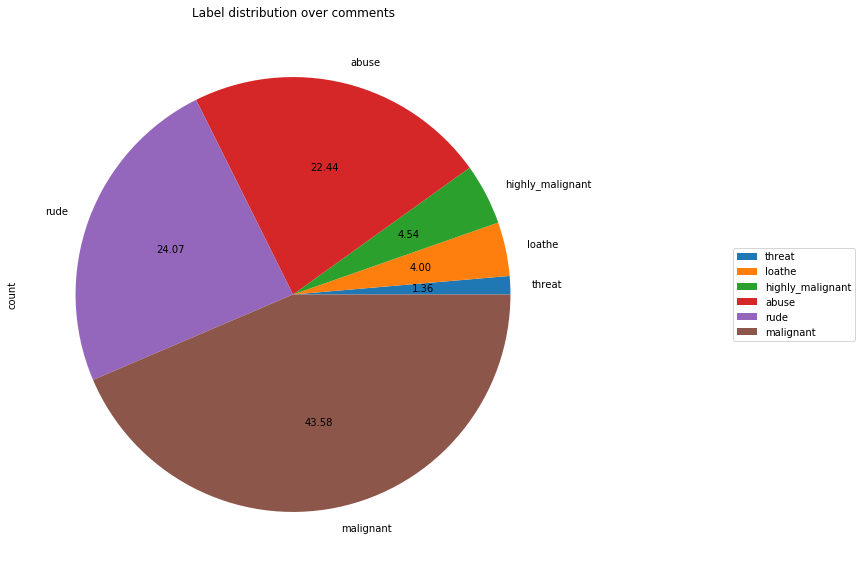

In [7]:
# Label distribution comments in pie chart
comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
distribution = train[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (10, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

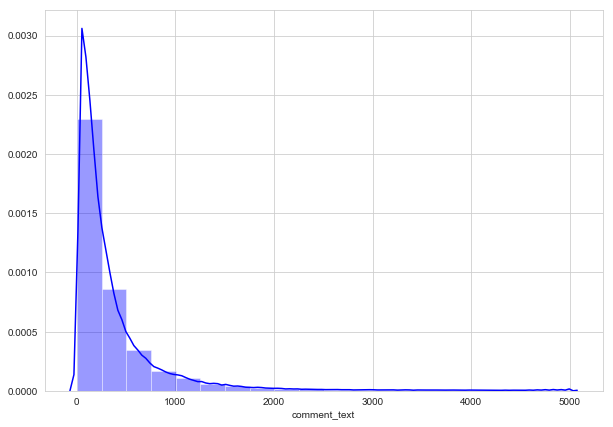

In [8]:
#Distribution of comments length
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, bins=20, color = 'blue')

In [9]:
train['comment_length']=train.comment_text.str.len()
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67


In [10]:
# Adding new column comment_length to check length of comment_text characters
test['comment_length']=test.comment_text.str.len()
test.head()

,id,comment_text,comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,00017563c3f7919a,":If you have a look back at the source, the in...",205
4,00017695ad8997eb,I don't anonymously edit articles at all.,41


### Plotting of WordCloud

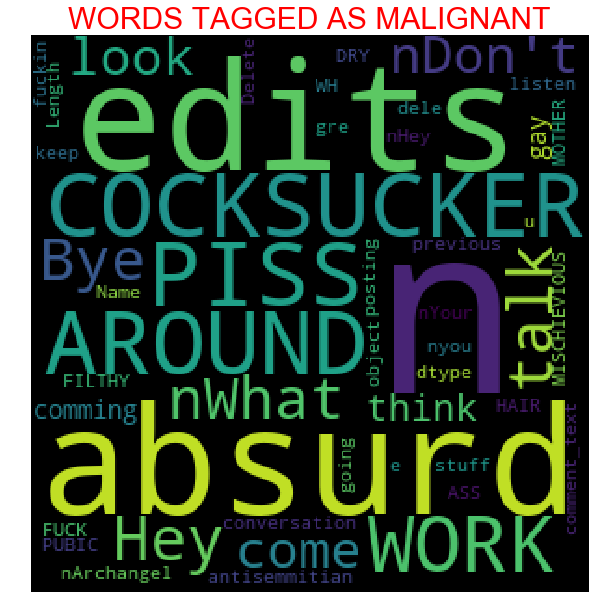

In [11]:
malignant=train[(train['malignant']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(malignant['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS MALIGNANT',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

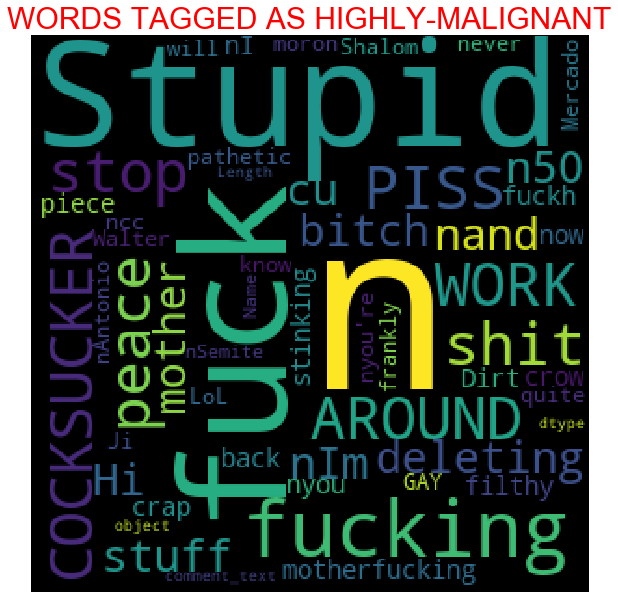

In [22]:
high_mal=train[(train['highly_malignant']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(high_mal['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS HIGHLY-MALIGNANT',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

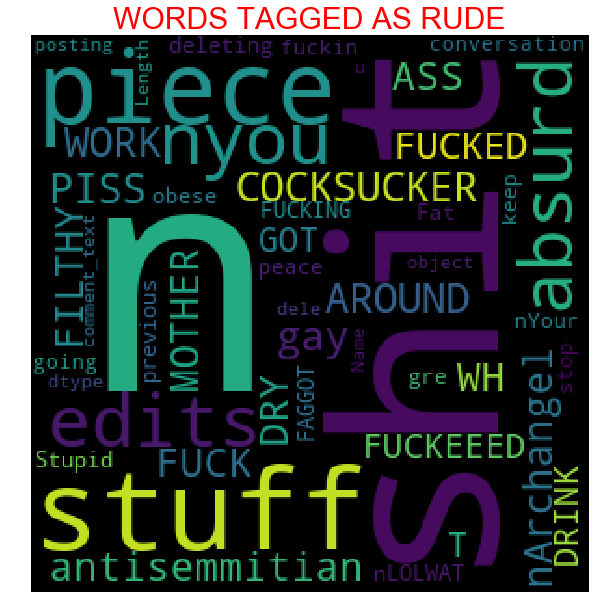

In [23]:
rude=train[(train['rude']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rude['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS RUDE',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

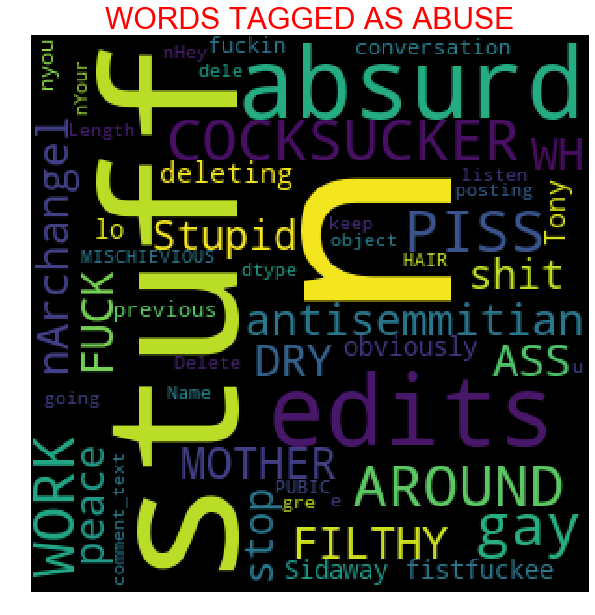

In [24]:
abuse=train[(train['abuse']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(abuse['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS ABUSE',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

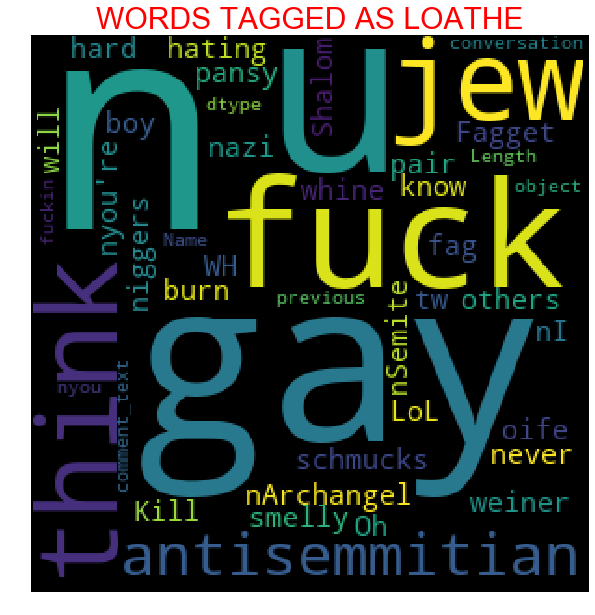

In [25]:
loathe=train[(train['loathe']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(loathe['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS LOATHE',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

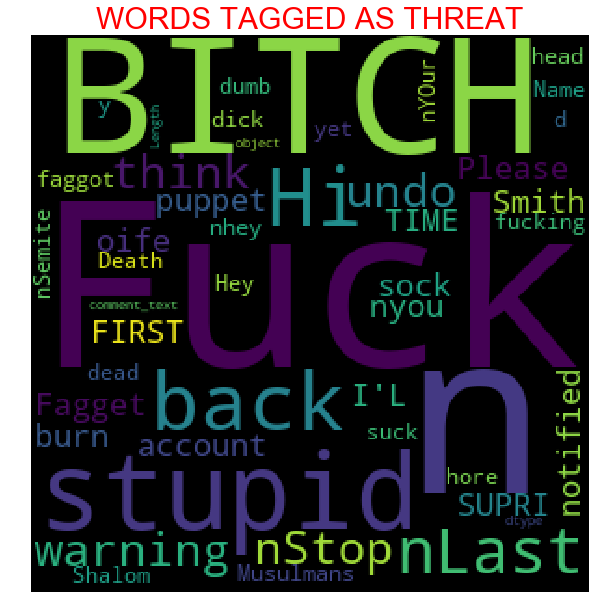

In [26]:
threat=train[(train['threat']==1)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(threat['comment_text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS THREAT',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

### Checking for correlation

In [27]:
## Check for correlation
train.corr()

,malignant,highly_malignant,rude,threat,abuse,loathe,label,comment_length
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,-0.967748,-0.054413
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,-0.298666,0.010175
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,-0.702812,-0.042910
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,-0.162925,-0.007917
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,-0.677324,-0.045027
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,-0.280144,-0.013628
label,-0.967748,-0.298666,-0.702812,-0.162925,-0.677324,-0.280144,1.000000,0.051643
comment_length,-0.054413,0.010175,-0.042910,-0.007917,-0.045027,-0.013628,0.051643,1.000000


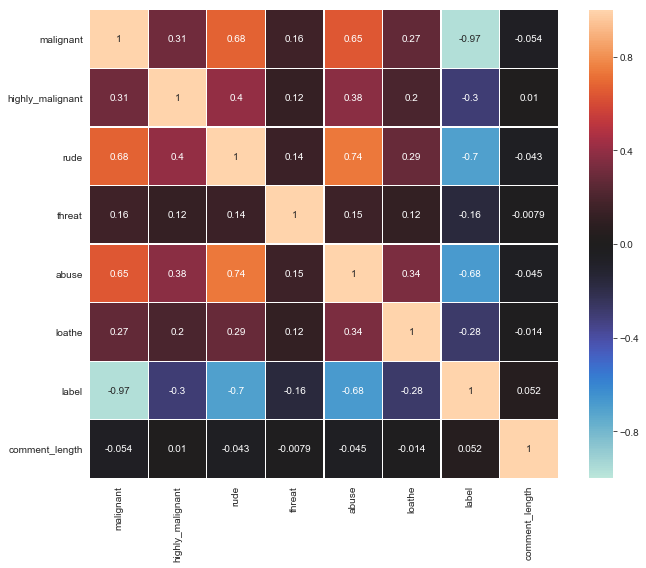

In [28]:
#Plotting heatmap for visualizing the correlation
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, square=True, center=0, fmt='.2g', linewidth=.1)
plt.tight_layout()

## Data Pre-Processing

Removing noise in data is very important. We will first normalize our text.

In [29]:
#nltk.download('averaged_perceptron_tagger')

In [12]:
#Creating a function to filter using POS tagging.

def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
# Function for data cleaning...
def Clean_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [14]:
# Cleaning  and storing the comments in a separate feature.
train["clean_comment_text"] = train["comment_text"].apply(lambda x: Clean_data(x))

In [ ]:
# Cleaning and storing the comments in a separate feature.
test["clean_comment_text"] = test["comment_text"].apply(lambda x: Clean_data(x))

In [16]:
# Adding new feature clean_comment_length to store length of cleaned comments in clean_comment_text characters
train['clean_comment_length'] = train['clean_comment_text'].apply(lambda x: len(str(x)))
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,comment_length,clean_comment_text,clean_comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits made under username hardcore...,184
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match this background colour seemingly stuck w...,74
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,really trying edit just that this constantly r...,164
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,more make real suggestion improvement wondered...,402
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember what page that,35


In [17]:
test['clean_comment_length'] = test['clean_comment_text'].apply(lambda x: len(str(x)))
test.head()

,id,comment_text,comment_length,clean_comment_text,clean_comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,bitch rule more succesful then ever whats with...,227
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,from title fine,15
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,source zawe ashton lapland,26
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,have look back source information updated corr...,140
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,anonymously edit article,24


Next we will convert tokens into vectors for moving forward to build machine learning model. 

In [18]:
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)
x=Tf_idf_train(train['clean_comment_text'])

print("Shape of x: ",x.shape)

y = train['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (159571, 43141)
Shape of y:  (159571,)


In [19]:
#Splitting the training and testing data 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)

In [20]:
#Importing required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [21]:
#Initializing the instance of the model
lr=LogisticRegression()
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
rf=RandomForestClassifier()
ab=AdaBoostClassifier()
gb=GradientBoostingClassifier()

models= []
models.append(('Logistic Regression',lr))
models.append(('DecisionTreeClassifier',dt))
models.append(('KNeighborsClassifier',knn))
models.append(('RandomForestClassifier',rf))
models.append(('AdaBoostClassifier',ab))
models.append(('GradientBoostingClassifier',gb))

*** Logistic Regression ***


accuracy_score:  0.9529578877005348


cross_val_score:  0.9537823308256245


roc_auc_score:  0.7892786644906702


Classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.58      0.72      4868
           1       0.95      0.99      0.97     43004

    accuracy                           0.95     47872
   macro avg       0.94      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



Confusion matrix: 

[[ 2842  2026]
 [  226 42778]]


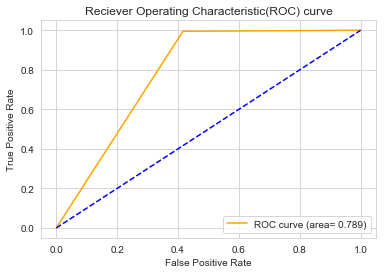




*** DecisionTreeClassifier ***


accuracy_score:  0.937917780748663


cross_val_score:  0.9380213133700785


roc_auc_score:  0.8217133228782982


Classification report:
 
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      4868
           1       0.96      0.97      0.97     43004

    accuracy                           0.94     47872
   macro avg       0.83      0.82      0.83     47872
weighted avg       0.94      0.94      0.94     47872



Confusion matrix: 

[[ 3290  1578]
 [ 1394 41610]]


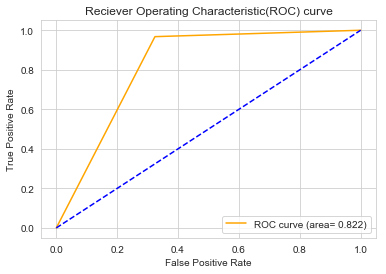




*** KNeighborsClassifier ***


accuracy_score:  0.8386112967914439


cross_val_score:  0.8471464524877395


roc_auc_score:  0.6074964878771094


Classification report:
 
              precision    recall  f1-score   support

           0       0.26      0.32      0.29      4868
           1       0.92      0.90      0.91     43004

    accuracy                           0.84     47872
   macro avg       0.59      0.61      0.60     47872
weighted avg       0.85      0.84      0.85     47872



Confusion matrix: 

[[ 1545  3323]
 [ 4403 38601]]


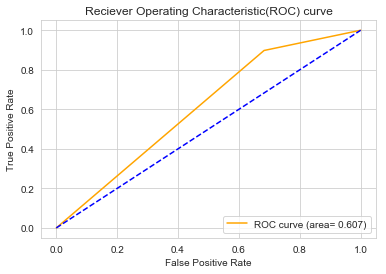




*** RandomForestClassifier ***


accuracy_score:  0.9510987633689839


cross_val_score:  0.9515137516440152


roc_auc_score:  0.7815036047553467


Classification report:
 
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      4868
           1       0.95      0.99      0.97     43004

    accuracy                           0.95     47872
   macro avg       0.94      0.78      0.84     47872
weighted avg       0.95      0.95      0.95     47872



Confusion matrix: 

[[ 2768  2100]
 [  241 42763]]


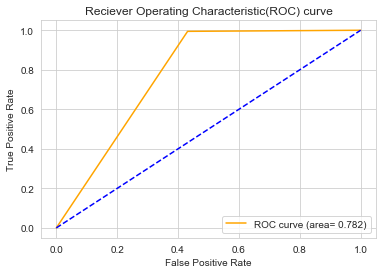




*** AdaBoostClassifier ***


accuracy_score:  0.9444351604278075


cross_val_score:  0.9457796177925338


roc_auc_score:  0.7607617972439092


Classification report:
 
              precision    recall  f1-score   support

           0       0.87      0.53      0.66      4868
           1       0.95      0.99      0.97     43004

    accuracy                           0.94     47872
   macro avg       0.91      0.76      0.81     47872
weighted avg       0.94      0.94      0.94     47872



Confusion matrix: 

[[ 2581  2287]
 [  373 42631]]


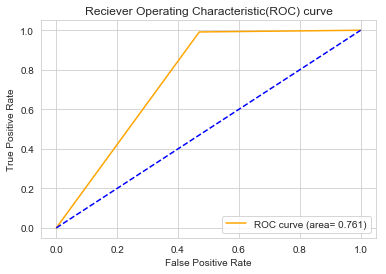




*** GradientBoostingClassifier ***


accuracy_score:  0.9396933489304813


cross_val_score:  0.9407536437789279


roc_auc_score:  0.7154037552219445


Classification report:
 
              precision    recall  f1-score   support

           0       0.94      0.43      0.59      4868
           1       0.94      1.00      0.97     43004

    accuracy                           0.94     47872
   macro avg       0.94      0.72      0.78     47872
weighted avg       0.94      0.94      0.93     47872



Confusion matrix: 

[[ 2112  2756]
 [  131 42873]]


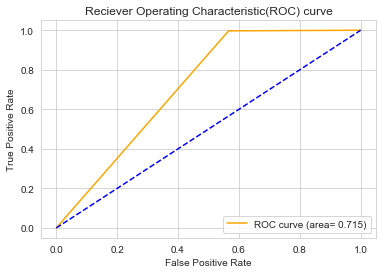

In [40]:
Model=[]
score=[]
cvs=[]
rocscore=[]
for name,model in models:
    print("***",name,"***")
    Model.append(name)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,y_pred)
    print('accuracy_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='accuracy').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    rocscore.append(roc_auc_score(y_test,y_pred)*100)
    print('roc_auc_score: ',roc_auc_score(y_test,y_pred))
    print('\n')
    print('Classification report:\n ')
    print(classification_report(y_test,y_pred))
    print('\n')
    print('Confusion matrix: \n')
    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    fpr, tpr, threshold= roc_curve(y_test,y_pred)
    plt.plot(fpr,tpr,color='orange',label='ROC curve (area= %0.3f)'%(roc_auc_score(y_test,y_pred)))
    plt.plot([0,1],[0,1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Reciever Operating Characteristic(ROC) curve')
    plt.legend(loc='lower right')
    plt.show() 
    print('\n\n')

In [41]:
df=pd.DataFrame({'Model':Model, 'Accuracy_score': score,'Cross_val_score':cvs,'ROC_Score':rocscore})
df

,Model,Accuracy_score,Cross_val_score,ROC_Score
0,Logistic Regression,95.295789,95.378233,78.927866
1,DecisionTreeClassifier,93.791778,93.802131,82.171332
2,KNeighborsClassifier,83.861130,84.714645,60.749649
3,RandomForestClassifier,95.109876,95.151375,78.150360
4,AdaBoostClassifier,94.443516,94.577962,76.076180
5,GradientBoostingClassifier,93.969335,94.075364,71.540376


Looking at various metrics we conclude decision tree model to be our best model.

In [22]:
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred= dt.predict(x_test)
score_dt=accuracy_score(y_test,y_pred)
print("DecisionTree Classifier model Score =",accuracy_score(y_test,y_pred))
print("Confusion Matrix :\n",confusion_matrix(y_test,y_pred),"\n")
print("Classification Report:\n",classification_report(y_test,y_pred,digits=2))

DecisionTree Classifier model Score = 0.9376044451871658
Confusion Matrix :
 [[ 3288  1580]
 [ 1407 41597]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69      4868
           1       0.96      0.97      0.97     43004

    accuracy                           0.94     47872
   macro avg       0.83      0.82      0.83     47872
weighted avg       0.94      0.94      0.94     47872



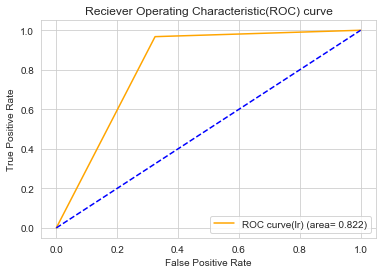

In [53]:
fpr, tpr, threshold= roc_curve(y_test,dt.predict(x_test))
plt.plot(fpr,tpr,color='orange',label='ROC curve(lr) (area= %0.3f)'%(roc_auc_score(y_test,dt.predict(x_test))))
plt.plot([0,1],[0,1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic(ROC) curve')
plt.legend(loc='lower right')
plt.show() 

### Saving Model

In [23]:
import pickle
filename= "MaligatCommentClassifier.pickle"
pickle.dump(dt,open(filename,'wb'))

### Data Pre-Processing of test data 

In [24]:
test.head()

,id,comment_text,comment_length,clean_comment_text,clean_comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,bitch rule more succesful then ever whats with...,227
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,from title fine,15
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,source zawe ashton lapland,26
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,have look back source information updated corr...,140
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,anonymously edit article,24


In [25]:
test.drop(columns=["id"],inplace=True)

In [26]:
def Tf_idf_test(text):
    tfid=TfidfVectorizer(max_features=43141,smooth_idf=False)
    return tfid.fit_transform(text)
x_test=Tf_idf_test(test['clean_comment_text'])
x_test.shape

(153164, 43141)

In [27]:
Predict=dt.predict(x_test)
test['Predicted Label']=Predict
test

,comment_text,comment_length,clean_comment_text,clean_comment_length,Predicted Label
0,Yo bitch Ja Rule is more succesful then you'll...,367,bitch rule more succesful then ever whats with...,227,1
1,== From RfC == \n\n The title is fine as it is...,50,from title fine,15,1
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,source zawe ashton lapland,26,1
3,":If you have a look back at the source, the in...",205,have look back source information updated corr...,140,1
4,I don't anonymously edit articles at all.,41,anonymously edit article,24,1
...,...,...,...,...,...
153159,". \n i totally agree, this stuff is nothing bu...",60,totally agree this stuff nothing long crap,42,1
153160,== Throw from out field to home plate. == \n\n...,198,throw from field home plate there faster throw...,111,1
153161,""" \n\n == Okinotorishima categories == \n\n I ...",423,okinotorishima category your change agree this...,286,1
153162,""" \n\n == """"One of the founding nations of the...",502,founding nation germany return quite similar i...,319,1


In [32]:
pred=test["Predicted Label"]

In [34]:
# Saving the Predicted values in csv file
test.to_csv('Malignant_Comment_Predicted_Values.csv')